# Basic Air Conditioning Processes
---

This notebook demonstrates how basic air conditioning processes can be solved with the package `hvac.air_conditioning`. Air conditioning processes are modeled by the `AirConditioningProcess` class:

In [1]:
from hvac.air_conditioning import AirConditioningProcess

Together with this class some other classes from the `hvac` package will be needed:

In [2]:
from hvac import Quantity
from hvac.fluids import HumidAir, Fluid
from hvac.charts import PsychrometricChart, StatePoint

- Class `Quantity` represents a physical quantity (see third-party package [**Pint**](https://pint.readthedocs.io/en/stable/)).
- Humid air is represented by the class `HumidAir`, which forms an object-oriented wrapper around the function `HAPropsSI` of the third-party package [**CoolProp**](http://www.coolprop.org/).
- Processes like humidification and dehumidification imply the presence of water. To get the thermodynamic properties of water we will use the `Fluid` class, which is also a wrapper around the [low-level user interface of CoolProp](http://www.coolprop.org/coolprop/LowLevelAPI.html).
- The `PsychrometricChart` and `StatePoint` classes can be used to draw airconditioning processes on a psychrometric chart.

To get a specific fluid, the `Fluid` class is instantiated with the name of the specific fluid (water in this case):

In [3]:
Water = Fluid('Water')

> Any fluid can be "created" this way, as long as the fluid name is known by CoolProp. A [list of the available fluids](http://www.coolprop.org/fluid_properties/PurePseudoPure.html#list-of-fluids) can be found in CoolProp's documentation.

Before we start demonstrating the use of the `AirConditioningProcess` class, we define a shortcut for creating `Quantity` instances:

In [4]:
Q_ = Quantity

## 1. Sensible Heating Process

*A heating coil heats 1.5 m<sup>3</sup>/s of moist air, initially at a state of 21 °C dry-bulb, 15 °C wet-bulb and 101.325 kPa barometric pressure, by 20 degrees. Calculate the load on the heating coil.*

**Air state at heating coil entrance**
- dry-bulb temperature `Tdb` = 21 °C
- wet-bulb temperature `Twb`= 15 °C

In [6]:
air_in = HumidAir(Tdb=Q_(21, 'degC'), Twb=Q_(15, 'degC'))

**Air state at heating coil exit**
- dry-bulb temperature `Tdb` = 41 °C
- moisture content `W` remains constant in a sensible heating process

In [7]:
air_out = HumidAir(Tdb=Q_(41, 'degC'), W=air_in.W)

**Dry air mass flow rate through heating coil**
- air volume flow rate at entrance of battery = 1.5 m³/s
- the dry-air density `rho` of the inlet air is known from the inlet condition of air

In [8]:
V_a = Q_(1.5, 'm ** 3 / s')
m_da = air_in.rho * V_a

**Heating coil load**

Knowing the state of both the inlet and outlet air and the mass flow rate of air flowing through the heating coil, the sensible heating process can be defined. To retrieve the load on the heating coil, we first create an instance of the `AirConditioningProcess` class with the known process parameters:

In [9]:
heating_coil = AirConditioningProcess(
    air_in=air_in,
    air_out=air_out,
    m_da=m_da,
)

The heating load can now be retrieved through the property `Q` of the `AirConditioningProcess` object, which will return a `Quantity` object. 

In [10]:
print(f"heating coil load = {heating_coil.Q.to('kW'):~P.3f}")

heating coil load = 36.258 kW


**Psychrometric chart**

The sensible heating process can be drawn on a psychrometric chart. The code below shows how to do this. First, an instance of the `PsychrometricChart` class is created. Then its method `plot_process` is called. The process is given a meaningful name and its start and end point are specified. A point on the psychrometric chart, of which the coordinates are dry-bulb temperature `Tdb` and absolute humidity ratio `W`, is represented by a `StatePoint` object. To display the chart, the method `show` on the `PsychrometricChart` object is called.

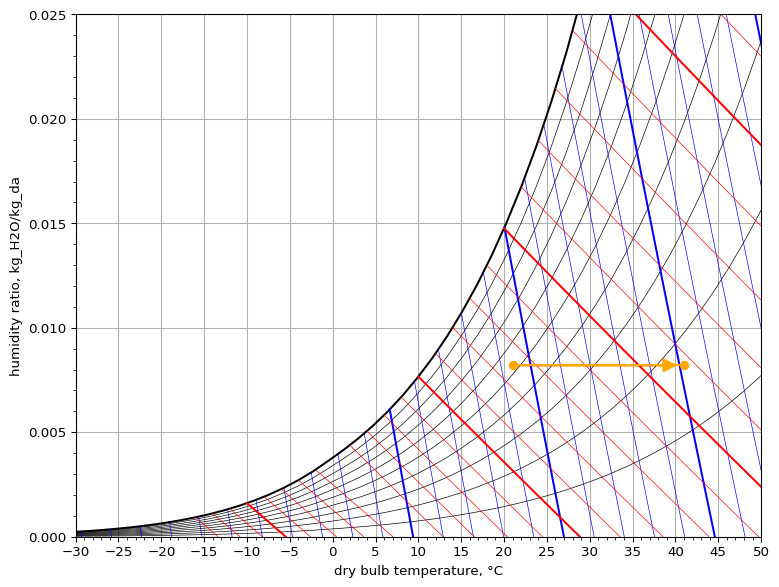

In [11]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='sensible heating',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 2. Cooling and Dehumidification Process

*1.5 m<sup>3</sup>/s of moist air at a state of 28 °C dry-bulb, 20.6 °C wet-bulb and 101.325 kPa flows across a cooler coil and leaves the coil at 12.5 °C dry-bulb and 8.336 g per kg of dry air. Calculate the apparatus dew point, the contact factor and the cooling load.*

**Air state at cooling coil entrance**
- dry-bulb temperature `Tdb` = 28.0 °C
- wet-bulb temperature `Twb`= 20.6 °C

In [12]:
air_in = HumidAir(Tdb=Q_(28.0, 'degC'), Twb=Q_(20.6, 'degC'))

**Air state at cooling coil exit**
- dry-bulb temperature `Tdb` = 12.5 °C
- humidity ratio `W` = 8.336 g/kg

In [13]:
air_out = HumidAir(Tdb=Q_(12.5, 'degC'), W=Q_(8.336, 'g / kg'))

**Dry air mass flow rate through cooling coil**
- air volume flow rate at entrance of battery = 1.5 m³/s
- the dry-air density `rho` of the inlet air is known from the inlet air state

In [14]:
V = Q_(1.5, 'm ** 3 / s')
m_da = air_in.rho * V

**Cooling coil load**<br>
The small energy content of the condensate draining from the cooling coil surface will be ignored. For this we set the parameters `m_w` (i.e. the mass flow rate of water condensate) and `h_w` (i.e. the enthalpy of the condensate) to zero.

In [15]:
air_cooler = AirConditioningProcess(
    air_in=air_in,
    air_out=air_out,
    m_da=m_da,
    m_w=Q_(0.0, 'kg / s'),
    h_w=Q_(0.0, 'J / kg')
)
print(f"cooling load = {air_cooler.Q.to('kW'):~P.3f}")

cooling load = -44.429 kW


**Apparatus dew point (ADP) temperature**<br>
The "apparatus dew point" (ADP) of a cooling coil is the point on the psychrometric diagram where the cooling process line intersects the saturation line of humid air. The relative humidity in the ADP is therefore always 100 %, which means it is sufficient to find its dry-bulb temperature. After the air cooling process has been defined and is fully determined (i.e. it is solvable), we can access the ADP through the property `ADP` of our `AirConditioningProcess` object.

In [16]:
print(f"ADP temperature = {air_cooler.ADP.Tdb.to('degC'):~P.1f}")

ADP temperature = 10.2 °C


**Contact factor**<br>
The cooling process in a real air cooling coil could be considered as an adiabatic mixing process of an air stream flowing through a "perfect" air cooling coil, where it is cooled to the ADP of the cooling coil, and an air stream that bypasses the "perfect" air cooling coil, thus remaining at the inlet air state. The contact factor, designated by `beta`, is then defined as the fraction of the air that passes through the "perfect" air cooling coil.

In [17]:
print(f"contact factor = {air_cooler.beta.to('frac'):~P.2f}")

contact factor = 0.87 frac


**Psychrometric chart**

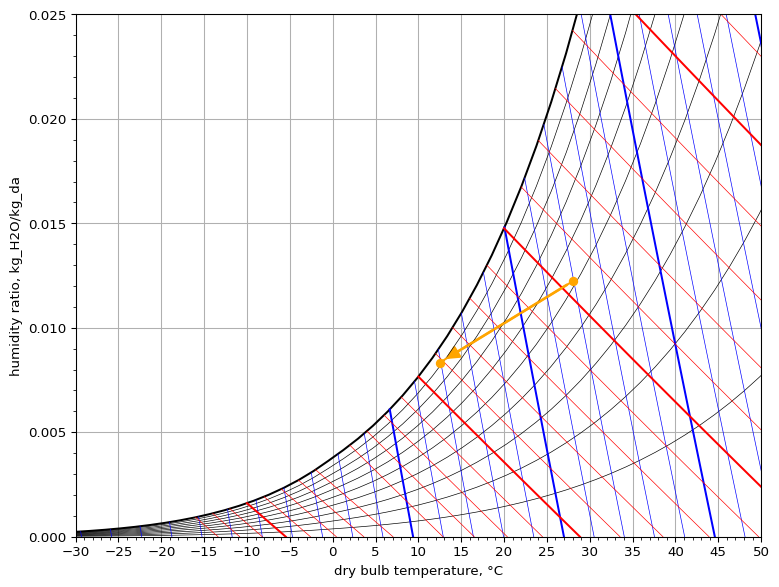

In [18]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='air cooling',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 3. Evaporative Cooling Process (1)

*Ambient air at 38°C db-temperature and 20°C wb-temperature enters an evaporative cooler with a dry air mass flow rate of 0.75 kg/s. The pressure is constant at 95 kPa. The air leaves at a db-temperature of 25°C. Calculate (1) the relative humidity of the air at the inlet, (2) the relative humidity of the air at the exit, (3) the rate of flow of water to the cooler, and (4) the saturation effectiveness of the cooler.*

> Notice that the atmospheric pressure is given to be 95 kPa, instead of standard atmospheric pressure (101.325 kPa). By default the `HumidAir` class determines the state of humid air at standard atmospheric pressure  (i.e. at sea level). In that case, passing only two input state properties to the constructor of the `HumidAir` class is sufficient to determine the state of the humid air. However, if the atmospheric pressure is different from standard pressure, we also need to pass the actual atmospheric pressure to the constructor, using parameter `P`.

**State of air entering the evaporative cooler**

In [19]:
air_in = HumidAir(Tdb=Q_(38.0, 'degC'), Twb=Q_(20.0, 'degC'), P=Q_(95, 'kPa'))
print(f"relative humidity of the air at inlet = {air_in.RH.to('pct'):~P.0f}")

relative humidity of the air at inlet = 19 %


**State of air leaving the evaporative cooler**<br>
Evaporative cooling is known to be a constant wet-bulb temperature process, which means that the wet-bulb temperature of the leaving air will be the same as that of the entering air.

In [20]:
air_out = HumidAir(Tdb=Q_(25.0, 'degC'), Twb=air_in.Twb, P=Q_(95, 'kPa'))
print(f"relative humidity of the air at outlet = {air_out.RH.to('pct'):~P.0f}")

relative humidity of the air at outlet = 64 %


**Make-up water**<br>
It is reasonably assumed that under steady-state operation the liquid make-up water being supplied to the cooler has a temperature that is equal to the wet-bulb temperature of the process. Theoretically, the wet-bulb temperature of the entering air is the lowest temperature that can be attained by evaporative cooling in an adiabatic saturator.

In [21]:
water = Water(T=air_in.Twb, P=Q_(95.0, 'kPa'))

[hvac.fluids.fluid | WARNING] CoolProp could not solve for quantity 'sigma: surface tension is only defined within the two-phase region; Try PQ or QT inputs'


**Saturated state of leaving air and ADP**<br>
In an adiabatic saturator the air stream, while being cooled due to the evaporation of water that is taking sensible heat from the air, would continue to absorb water vapor until the air is fully saturated. Once fully saturated (RH = 100%) the energy transfer between air and water will cease, as the air cannot take up any more water vapor. At this saturated state the dry-bulb temperature of the air stream at the outlet of the adiabatic saturator will be maximally reduced to the wet-bulb temperature of the entering air. This saturated state, marked by a point on the saturation line of humid air, is denoted by `ADP`, in analogy with the "Apparatus Dew Point" of an air cooler.

In [22]:
adp = HumidAir(Tdb=air_in.Twb, RH=Q_(100.0, 'pct'), P=Q_(95, 'kPa'))

**Evaporative cooling**<br>
In an evaporative cooler there is no external heat transfer between the system of air and water and its environment, so `Q` must be set to zero. From an energy balance of the system the mass flow rate `m_w` at which water evaporates in the air stream can be solved. To get at the saturation effectiveness of the evaporative cooler, we need to pass the `ADP` state of the air (i.e. the saturated state of the air that would be attained in an adiabatic saturator). The saturation effectiveness is denoted by `beta`, in analogy with the contact factor of an air cooling coil.

In [23]:
cooler = AirConditioningProcess(
    air_in=air_in,
    air_out=air_out,
    m_da=Q_(0.75, 'kg / s'),
    h_w=water.h,
    Q=Q_(0.0, 'W'),
    ADP=adp
)
print(
    f"flow rate of evaporating water to the air stream = {cooler.m_w.to('kg / s'):~P.3f}\n"
    f"saturation effectiveness of the cooler = {cooler.beta.to('frac'):~P.2f}"
)

flow rate of evaporating water to the air stream = 0.004 kg/s
saturation effectiveness of the cooler = 0.72 frac


## 4. Evaporative Cooling Process (2)

*1.5 m<sup>3</sup>/s of moist air at a state of 15 °C dry-bulb, 10 °C wet-bulb, and 101.325 kPa barometric pressure, enters the spray chamber of an air washer. The humidifying efficiency of the washer is 90 %, all the spray water is recirculated, the spray chamber and the tank are perfectly lagged, and mains water at 10 °C is supplied to make good the losses due to evaporation. Calculate the state of the air leaving the washer.*

**State of air entering the spray chamber**
- dry-bulb temperature `Tdb` = 15 °C
- wet-bulb temperature `Twb` = 10 °C

In [24]:
air_in = HumidAir(Tdb=Q_(15.0, 'degC'), Twb=Q_(10.0, 'degC'))

**Dry air mass flow rate through the spray chamber**
- volume flow rate of inlet air = 1.5 m<sup>3</sup>/s
- density `rho` of inlet air is known from given state of inlet air

In [25]:
V_moist = Q_(1.5, 'm ** 3 / s')
m_da = air_in.rho * V_moist

**State of air leaving the spray chamber**<br>
Besides the inlet air state, the air washer efficiency, and the mass flow rate of dry air, it also follows from the problem statement that no heat transfer is taking place in the air washer between the air stream and the environment (i.e. adiabatic process). Consequently, `Q` can be set to zero. The ADP of the air washer follows from the wet-bulb temperature of the air entering the spray chamber. As the ADP is situated on the saturation line of humid air, its relative humidity equals 100 %.

In [26]:
air_washer = AirConditioningProcess(
    air_in=air_in,
    beta=Q_(90.0, 'pct'),
    ADP=HumidAir(Tdb=air_in.Twb, RH=Q_(100.0, 'pct')),
    m_da=m_da,
    Q=Q_(0.0, 'W')
)
print(
    f"dry-bulb temperature = {air_washer.air_out.Tdb.to('degC'):~P.1f}\n"
    f"humidity ratio = {air_washer.air_out.W.to('g/kg'):~P.0f}"
)

dry-bulb temperature = 10.4 °C
humidity ratio = 7 g/kg


**Mass flow rate of make-up water**

In [27]:
print(f"mass flow rate of make-up water = {air_washer.m_w.to('kg/hr'):~P.3f}")

mass flow rate of make-up water = 12.119 kg/h


**Psychrometric chart**

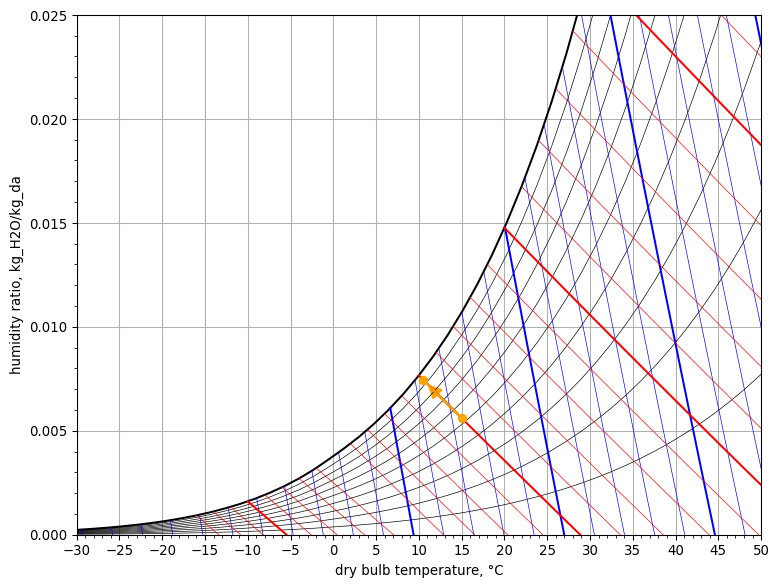

In [29]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='evaporative cooling',
    start_point=StatePoint(air_washer.air_in.Tdb, air_washer.air_in.W),
    end_point=StatePoint(air_washer.air_out.Tdb, air_washer.air_out.W)
)
psych_chart.show()

## 5. Cooling and Humidification by Water Injection

*Moist air at a state of 21 °C dry-bulb, 15 °C wet-bulb, and 101.325 kPa barometric pressure enters a spray chamber. For each kilogram of dry air passing through the chamber, 0.002 kg of water at 100 °C is injected and totally evaporated. Calculate moisture content, enthalpy and dry-bulb temperature of the moist air leaving the chamber.*

**State of air entering the spray chamber**

- dry-bulb temperature `Tdb` = 21 °C
- wet-bulb temperature `Twb` = 15 °C

In [28]:
air_in = HumidAir(Tdb=Q_(21.0, 'degC'), Twb=Q_(15.0, 'degC'))

**Dry air mass flow rate through the spray chamber**

- mass flow rate of dry air = 1.0 kg/s 

In [29]:
m_da = Q_(1.0, 'kg / s')

**Mass flow rate of injected water**
- mass flow rate of water = 0.002 kg/s

In [30]:
m_w = Q_(0.002, 'kg / s')

**State of injected water**

- water temperature `T` = 100 °C
- liquid water at 100 °C and atmospheric pressure is saturated, so its vapor quality `x` is 0 %.

In [31]:
water = Water(T=Q_(100.0, 'degC'), x=Q_(0.0, 'pct'))

**State of air leaving the spray chamber**<br>
In a spray chamber only water is injected into the air stream. No external heat is transferred to or extracted from the air stream, so `Q` can be set to zero.

In [32]:
spray_chamber = AirConditioningProcess(
    air_in=air_in,
    m_da=m_da,
    m_w=m_w,
    h_w=water.h,
    Q=Q_(0.0, 'W')
)
print(
    f"outlet air moisture content = {spray_chamber.air_out.W.to('g/kg'):~P.3f}\n"
    f"outlet air enthalpy = {spray_chamber.air_out.h.to('kJ/kg'):~P.0f}\n"
    f"outlet air dry-bulb temperature = {spray_chamber.air_out.Tdb.to('degC'):~P.1f}"
)

outlet air moisture content = 10.206 g/kg
outlet air enthalpy = 43 kJ/kg
outlet air dry-bulb temperature = 16.8 °C


**Psychrometric chart**

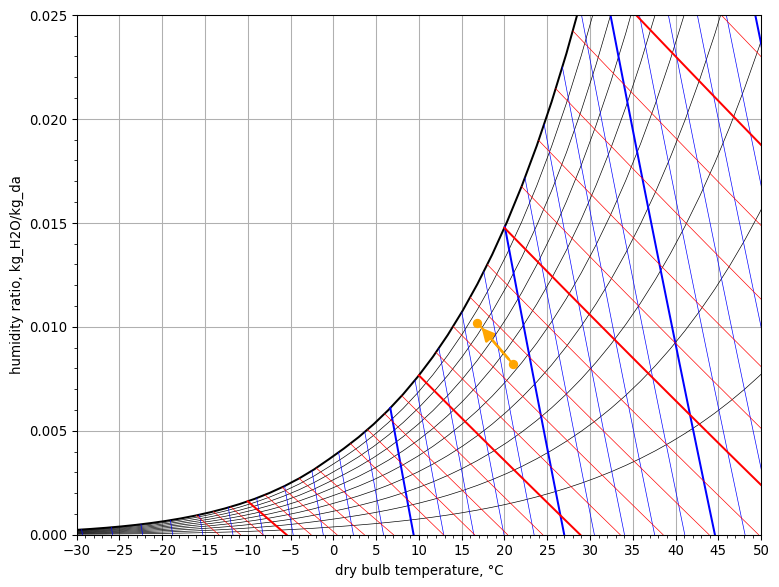

In [35]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='water injection',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 6. Humidification by Steam Injection (saturated steam at 100 °C)

*Dry saturated steam at 100 °C is injected at a rate of 0.01 kg/s into a moist airstream moving at a rate of 1 kg of dry air per second and initially at a state of 28 °C dry-bulb, 11.9 °C wet-bulb and 101.325 kPa barometric pressure. Calculate the leaving state of the moist airstream.*

**Entering air state**
- dry-bulb temperature `Tdb` = 28 °C
- wet-bulb temperature `Twb`= 11.9 °C

In [36]:
air_in = HumidAir(Tdb=Q_(28.0, 'degC'), Twb=Q_(11.9, 'degC'))

**Dry air mass flow rate**

In [37]:
m_da = Q_(1.0, 'kg / s')

**State of injected steam**
- dry-bulb temperature `T` = 100 °C
- saturated dry steam: vapor quality `x` is 100 %

In [33]:
steam = Water(T=Q_(100.0, 'degC'), x=Q_(100, 'pct'))
print(
    f"steam pressure (abs) = {steam.P.to('bar'):~P.3f}\n"
    f"steam enthalpy = {steam.h.to('kJ / kg'):~P.3f}"
)

steam pressure (abs) = 1.014 bar
steam enthalpy = 2675.570 kJ/kg


**Mass flow rate of steam**

In [34]:
m_w = Q_(0.01, 'kg / s')

**Leaving air state**

In [35]:
steam_injection = AirConditioningProcess(
    air_in=air_in,
    m_da=m_da,
    Q=Q_(0.0, 'W'),
    h_w=steam.h,
    m_w=m_w
)
print(
    f"outlet air moisture content = {steam_injection.air_out.W.to('g/kg'):~P.3f}\n"
    f"outlet air enthalpy = {steam_injection.air_out.h.to('kJ/kg'):~P.3f}\n"
    f"outlet air dry-bulb temperature = {steam_injection.air_out.Tdb.to('degC'):~P.1f}"
)

outlet air moisture content = 18.206 g/kg
outlet air enthalpy = 68.565 kJ/kg
outlet air dry-bulb temperature = 22.2 °C


**Psychrometric chart**

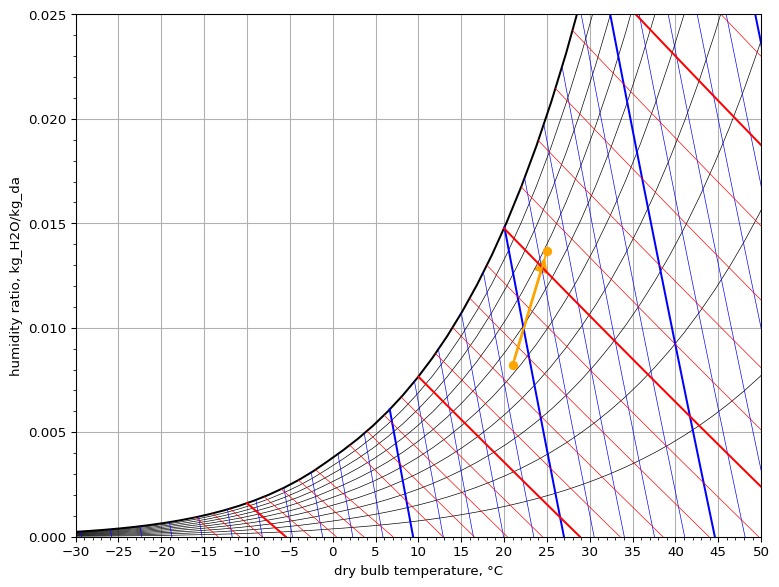

In [36]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='steam injection',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 7. Humidification by Steam Injection (saturated steam at 30 bar)

*Dry saturated steam at 30 bar is injected at a rate of 0.01 kg/s into a moist airstream moving at a rate of 1 kg of dry air per second and initially at a state of 28 °C dry-bulb, 11.9 °C wet-bulb and 101.325 kPa barometric pressure. Calculate the leaving state of the moist airstream.*

**Entering air state**
- dry-bulb temperature `Tdb` = 28 °C
- wet-bulb temperature `Twb` = 11.9 °C

In [37]:
air_in = HumidAir(Tdb=Q_(28.0, 'degC'), Twb=Q_(11.9, 'degC'))
print(f"RH of inlet air = {air_in.RH.to('pct'):~P.0f}")

RH of inlet air = 9 %


**Dry air mass flow rate**

In [43]:
m_da = Q_(1.0, 'kg / s')

**State of injected steam**
- steam pressure `P`= 30 bar
- saturated steam: vapor quality `x` is 100 %

In [38]:
steam = Water(P=Q_(30.0, 'bar'), x=Q_(100, 'pct'))
print(
    f"steam temperature = {steam.T.to('degC'):~P.1f}\n"
    f"steam enthalpy = {steam.h.to('kJ / kg'):~P.3f}"
)

steam temperature = 233.9 °C
steam enthalpy = 2803.153 kJ/kg


**Mass flow rate of steam**

In [45]:
m_w = Q_(0.01, 'kg / s')

**Leaving air state**

In [39]:
steam_injection = AirConditioningProcess(
    air_in=air_in,
    m_da=m_da,
    Q=Q_(0.0, 'W'),
    h_w=steam.h,
    m_w=m_w
)
print(
    f"outlet air moisture content = {steam_injection.air_out.W.to('g/kg'):~P.3f}\n"
    f"outlet air enthalpy = {steam_injection.air_out.h.to('kJ/kg'):~P.3f}\n"
    f"outlet air dry-bulb temperature = {air_out.Tdb.to('degC'):~P.1f}"
)

outlet air moisture content = 12.129 g/kg
outlet air enthalpy = 61.624 kJ/kg
outlet air dry-bulb temperature = 25.0 °C


**Psychrometric chart**

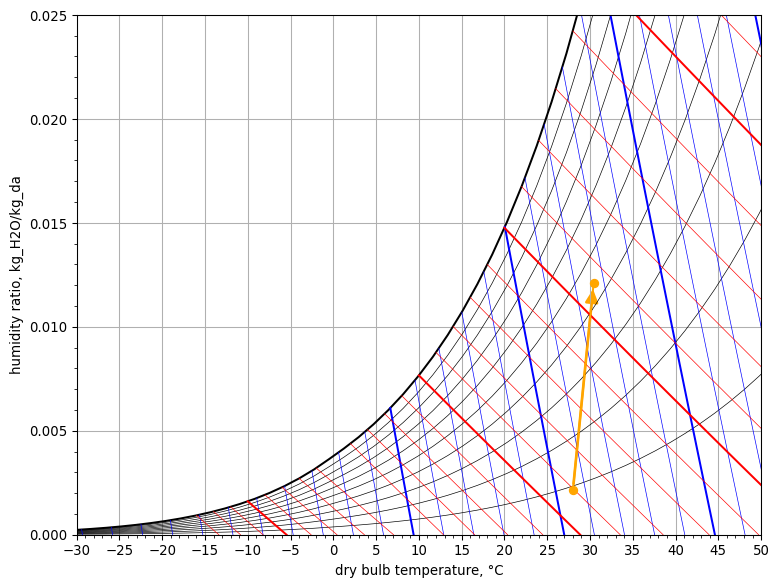

In [47]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='steam injection',
    start_point=StatePoint(air_in.Tdb, air_in.W),
    end_point=StatePoint(air_out.Tdb, air_out.W)
)
psych_chart.show()

## 8. Adiabatic Mixing of Air Streams

*In an air conditioning system return air at 26°C dry-bulb temperature and 50% relative humidity is mixed with outdoor ambient air at 34°C dry-bulb temperature and 60 % relative humidity. The dry air mass flow rate of outdoor air is 30% of the supply air mass flow rate to the space. The pressure is constant at 101.3 kPa. Calculate (1) the enthalpy, (2) the humidity ratio, and (3) the dry-bulb temperature of the supply air.*

**Return air**
- dry-bulb temperature `Tdb` = 26°C
- relative humidity `RH` = 50%

In [40]:
return_air = HumidAir(Tdb=Q_(26.0, 'degC'), RH=Q_(50.0, 'pct'))

**Outdoor ambient air**

- dry-bulb temperature `Tdb` = 34°C
- relative humidity `RH` = 60%

In [41]:
outdoor_air = HumidAir(Tdb=Q_(34.0, 'degC'), RH=Q_(60.0, 'pct'))

**Dry air mass flow rates**
- outdoor air = 0.3 kg/s
- return air = 1.0 - 0.3 = 0.7 kg/s
- supply air = 1.0 kg/s

**Adiabatic mixing**<br>
The adiabatic mixing of two incoming air streams is modeled by the `AdiabaticMixing` class. Air streams are modeled by the `AirStream` class. An `AirStream` instance combines the air state and the mass flow rate of an air stream.

In [42]:
from hvac.air_conditioning import AirStream, AdiabaticMixing

The state and mass flow rate of the two incoming air streams -the return air stream and the outdoor air stream- are known from the problem statement. Only the mass flow rate of the outgoing, mixed air stream -the supply air stream- is known.

In [43]:
return_air = AirStream(state=return_air, m_da=Q_(0.7, 'kg / s'))
outdoor_air = AirStream(state=outdoor_air, m_da=Q_(0.3, 'kg / s'))
supply_air = AirStream(m_da=Q_(1.0, 'kg / s'))  # state still unknown

The incoming air streams are passed to the parameters `in1` and `in2` of the `AdiabaticMixing` class constructor. The outgoing, mixed air stream is assigned to parameter `out`.

In [44]:
mixing_chamber = AdiabaticMixing(in1=outdoor_air, in2=return_air, out=supply_air)

**Supply air**<br>
The missing supply air state is immediately solved for when instantiating the `AdiabaticMixing` class. The complete solution for the supply air stream is now available through the property `stream_out` of the `AdiabaticMixing` instance.

In [45]:
supply_air = mixing_chamber.stream_out
print(
    f"enthalpy of supply air = {supply_air.state.h.to('kJ / kg'):~P.3f}\n"
    f"humidity ratio of supply air = {supply_air.state.W.to('g / kg'):~P.1f}\n"
    f"dry-bulb temperature of supply air = {supply_air.state.Tdb.to('degC'):~P.1f}"
)

enthalpy of supply air = 62.989 kJ/kg
humidity ratio of supply air = 13.5 g/kg
dry-bulb temperature of supply air = 28.4 °C


**Psychrometric chart**

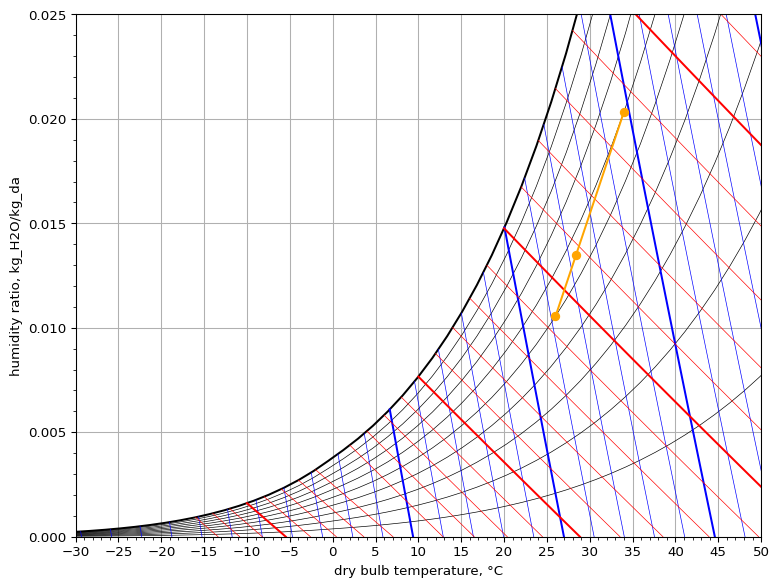

In [47]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='adiabatic mixing',
    start_point=StatePoint(return_air.Tdb, return_air.W),
    end_point=StatePoint(outdoor_air.Tdb, outdoor_air.W),
    mix_point=StatePoint(supply_air.Tdb, supply_air.W)
)
psych_chart.show()